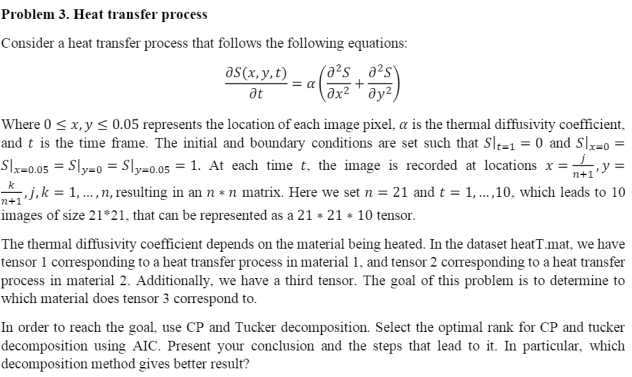

In order to solve this problem, I will perform tensor decomposition on all three tensors and compare tensors to determine if tensor #3 is representative of materials 1 or 2. As the instructions don't specifically state the method of comparison we are to use, I will explain my methodology along with giving my final answer.

In [1]:
import matplotlib.pyplot as plt
import tensorly as tl
from itertools import product
import numpy as np
import tensorly.decomposition
import scipy.io
from scipy.spatial.distance import cdist

In [2]:
mat = scipy.io.loadmat(r'../heatT.mat')

In [3]:
T1 = mat['T1'][0][0][0]
T2 = mat['T2'][0][0][0]
T3 = mat['T3'][0][0][0]

Above, I load the raw data, and extract the three separate tensors. Then, I will perform both CP and Tucker decomposition to be able to compare across both types of decomposition. 

However, before being able to decompose the tensors and compare the decompositions, I need to find the optimal decomposition by tuning the rank for the CP decomposition, and the tensor size of the decomposed Tucker tensor, for each tensor 1-3. This process will be performed below, and tuning will be based on calculating the AIC for each decomposition compared against the rank, or size. 

# CP Decomposition

In [4]:
def cp_tuner(X,maxrank,seed=2022):
    np.random.seed(seed)
    err = []
    iters = range(1,maxrank+1)
    for i in iters:
        CP_Heat = tl.decomposition.parafac(X,i)
        reconstructed = tl.kruskal_to_tensor(CP_Heat)
        err.append(((X-reconstructed)**2).sum())
    AIC = [2*e + 2*(i+1) for i,e in enumerate(err)]
    min_AIC = min(AIC)
    ind_min = int(np.argwhere(np.array(AIC) == min_AIC)[0])
    best_rank = iters[ind_min]
    final_CP = tl.decomposition.parafac(X,best_rank)
    return AIC, best_rank, final_CP[1]

Above, I have defined a function that, for an input tensor, calculates the AIC for a given decomposition across a range of ranks, dependent on the max rank value desired for testing, which is input in the functiton. 

To calculate the AIC, for each rank value, the CP decomposition is created, and then reconstructed to recuperate an approximation of the original matrix. Then, the original matrix and the new approximation are compared, and the Sum of Squares is taken. However, since the sum of squares, or error, will always be decreasing for higher rank decompositions, we can use the AIC to weigh these decreases in error with the penalty of increasing the rank (as, ultimately, we desire a more simple structure, as is the purpose of decomposition!) 

In [5]:
AIC1,br_1,final_T1_CP = cp_tuner(T1,15)
AIC2,br_2,final_T2_CP = cp_tuner(T2,15)
AIC3,br_3,final_T3_CP = cp_tuner(T3,15)

In [6]:
for i,j in zip([1,2,3],[br_1,br_2,br_3]):
    print(f"The rank with the lowest AIC for tensor #{i} is: {j}")

The rank with the lowest AIC for tensor #1 is: 11
The rank with the lowest AIC for tensor #2 is: 6
The rank with the lowest AIC for tensor #3 is: 13


After using my function to tune the rank for the CP-decomposition of each tensor, I already notice right off the bat that Tensors 1 and 3 might have similar levels of complexity, due to the ranks being more similar. Now, to note, the results of decomposition and optimal rank highly vary on the seed that is used, but, assuming that the seed I have chosen is still "random", and that the purpose of this assignment is NOT to test various levels of seeds, I will stick with this result. 

Thus, in summary, I might already have a hunch that Tensor 3 is representative of **material 1**, due to having similar complexity, whereas tensor 2 can be well-represented by a decomposition of much lower rank/complexity. 

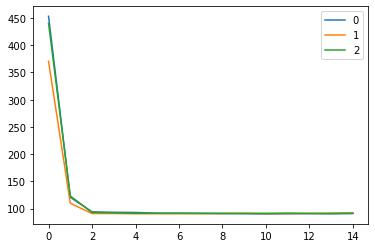

In [7]:
for ind,i in enumerate([AIC1,AIC2,AIC3]):
    plt.plot(i,label=ind)
    plt.legend()
plt.show()

Just as a visual, I plot the AIC curves above, and as can be seen, "1", or tensor 2, is the only one that has somewhat different values on the left side of the curve. 

Before I use the results of decomposition, I will also decompose the tensors using Tucker Decomposition first, and the final analysis will be below! 

# Tucker Decomposition

Similarly to above, now I will tune the tucker decomposition process, by tuning the dimensions of the smaller tensor created by tucker decomposition.

In [8]:
def tucker_tuner(X,maxrank):
    AIC = {}
    for i,j,k in product(range(1,maxrank+1),repeat=3):
        tucker_heat = tl.decomposition.tucker(X,[i,j,k])
        reconstructed = tl.tucker_to_tensor(tucker_heat)  
        e = ((X-reconstructed)**2).sum()
        n_params = i+j+k
        AIC[(i,j,k)] = 2*e + 2*n_params

    minIJK = min(AIC,key=AIC.get)
    minAIC = AIC[minIJK]
    tucker = tl.decomposition.tucker(X,minIJK)
    I,J,K = minIJK
    return AIC,minIJK,tucker 

As can be seen above, I create a function that tries all possible combinations of size for the resulting tensor, across all three dimensions, with values ranging from 1 to max-rank (which is defined in the function's use). The process for tuning is nearly identical to that above, first decomposing with the given tensor dimensions, then reconstructed, the error calculated across the re-construction and the original tensor, and finally the AIC calculated, to punish the error term for complexity (which, in this case, is being represented by the sum of dimensions). 

In [9]:
AIC1T,IJK1,Tucker1 = tucker_tuner(T1,10)
AIC2T,IJK2,Tucker2 = tucker_tuner(T2,10)
AIC3T,IJK3,Tucker3 = tucker_tuner(T3,10)

Above, I then use my function on all three tensors to tune them and finally output the final decomposed tensor parts.

In [10]:
for i,j in zip([1,2,3],[IJK1,IJK2,IJK3]):
    print(f"The dimensions with the lowest AIC for tensor #{i} is: {j}")

The dimensions with the lowest AIC for tensor #1 is: (3, 3, 3)
The dimensions with the lowest AIC for tensor #2 is: (3, 3, 3)
The dimensions with the lowest AIC for tensor #3 is: (3, 3, 3)


As can be seen, all three tensors have an optimal decomposed dimension of (3,3,3) with Tucker Decomposition! While this doesn't necessarily help in comparison, this might make it easier to compare numerically the similarity between the three tensors. 

Now that I have my optimal decompositions for all three tensors using both CP decomposition and Tucker decomposition, I can compare the final components in different ways to determine which material Tensor 3 might represent!

# Comparing Tensors 1 through 3

For both my CP and Tucker decomposition components, I will use a variety of methods to compare the three tensors, and hopefully come to a conclusion as to which material Tensor 3 belongs to. 

## Using CP Components:

For CP decomposition, I first visualize the raw matrix-form components, A,B,C to visualize them and look for potential similarities between the three tensors. It is unlikely that this will be enough to make any conclusions about similarities. Remember that the true decomposition are rank-1 tensors made of a_n, b_n, and c_n, which add together to form our final recreation of the original matrix. However, in this case, the a's, b's, and c's are put together to form a matrix. Thus, again, these images might not mean much, but I simply plot them to understand what the final decomposition components look like:

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Tensor 1's Components!


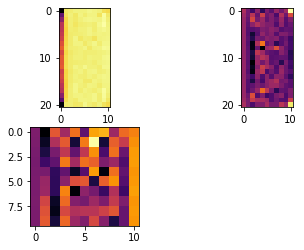

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Tensor 2's Components!


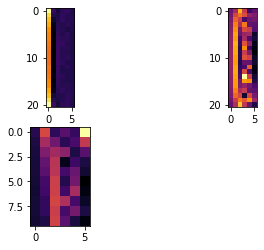

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Tensor 3's Components!


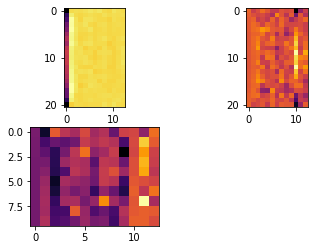

In [11]:
for ind,t in enumerate([final_T1_CP,final_T2_CP,final_T3_CP]):
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print(f"Tensor {ind+1}'s Components!")
    for i in range(len(t)):
        plt.subplot(2,2,i+1)
        plt.imshow(t[i],cmap='inferno')
    plt.show()

Despite my commentary above, I do notice that there are some similarities in the patterns of the values of the pixels (determined by their color) between tensor 1 and 3, which further inclines me to have a hunch that tensor 3 might belong to material 1. But let's look even further! 

A method suggested in Piazza by the TA's (a numerical method) involves taking the A and B matrices of (1) tensor 1 and 3, and then (2) tensor 2 and 3, and calculating the mean norm-distance between each column of each pair. The pair that might be the most likely to be similar would have a smaller distance. I calculate these mean norms below for both pairs, and print the final value. 

In [12]:
np.random.seed(2022)
P1 = tl.decomposition.parafac(T1, 11)
P3 = tl.decomposition.parafac(T3, 11)
diff = []

for i in range(10+1):
    A1 = P1[1][0][:,i]
    B1 = P1[1][1][:,i]
    XY1 = np.outer(A1, B1)
    A3 = P3[1][0][:,i]
    B3 = P3[1][1][:,i]
    XY3 = np.outer(A3, B3)
    diff.append(np.linalg.norm(XY1-XY3, 'fro'))
print(np.mean(diff))

3.5243167538220828


In [13]:
np.random.seed(2022)
P2 = tl.decomposition.parafac(T2, 11)
P3 = tl.decomposition.parafac(T3, 11)
diff = []

for i in range(10+1):
    A2 = P2[1][0][:,i]
    B2 = P2[1][1][:,i]
    XY2 = np.outer(A2, B2)
    A3 = P3[1][0][:,i]
    B3 = P3[1][1][:,i]
    XY3 = np.outer(A3, B3)
    diff.append(np.linalg.norm(XY1-XY3, 'fro'))
print(np.mean(diff))

9.861923340774288


As can be seen, Tensors 1 and 3s' components are more similar than 2 and 3s! 

---------------------

Next, as we learned in class, we can take the outer product of the first few components of the A and B matrices (as the C matrix refers to the temporal aspect of the tensor, which is the third dimension), to look for visual similarities between the 2D product of these components. I do this for the first 5 components in A and B, and plot them below! 

I also take the norm-distance of the product of each nth a and b component from tensor 1 and 3, and 2 and 3, and print the distance below each pair of three images, to serve as a numerical way to compare them as well, besides just using visuals to confirm similarity.

Thus, below, the left-most image in each row is the outer product of a_i and b_i for Tensor 1, the middle image for tensor 2, and the right-most image for tensor 3, for each i 0 through 4:

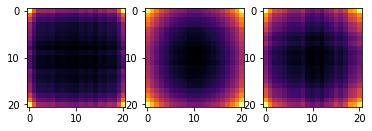

Norm of T1-T3:6.661145411927201
Norm of T2-T3:7.912273851398573


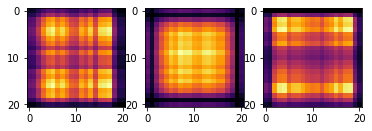

Norm of T1-T3:2.102269347652541
Norm of T2-T3:5.5447098008559665


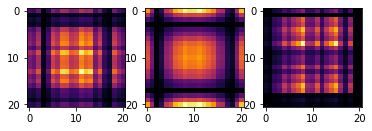

Norm of T1-T3:1.9489451188038684
Norm of T2-T3:2.7802191440144663


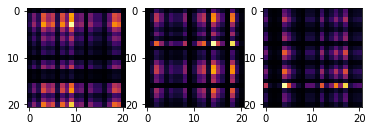

Norm of T1-T3:1.1610967884975965
Norm of T2-T3:1.14571471200309


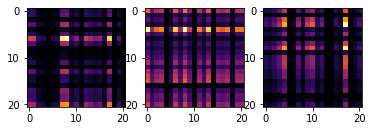

Norm of T1-T3:1.4825984897321047
Norm of T2-T3:1.2519308501107476


In [14]:
for i in range(5):
    cdists = []
    for ind,t in enumerate([final_T1_CP,final_T2_CP,final_T3_CP]):
        plt.subplot(1,3,ind+1)
        a1 = t[0][:,i]
        b1 = t[1][:,i]
        a1xb1 = np.abs(np.outer(a1,b1)).reshape((t[0].shape[0],t[0].shape[0]))
        plt.imshow(a1xb1,cmap='inferno')
        cdists.append(a1xb1)
    plt.show()
    print(f"Norm of T1-T3:{np.linalg.norm(cdists[0]-cdists[2])}")
    print(f"Norm of T2-T3:{np.linalg.norm(cdists[1]-cdists[2])}")

Notice again that for the first three components, which are arguably the more important ones, the outer-product of a_i and b_i for tensors 1 and 3 are more similar than those of tensors 2 and 3! Thus, even more reason to believe that tensor 3 is representative of material 1!! 

## Using Tucker Components:

Now, I will look at the components from Tucker decomposition. Remember that, with Tucker decomposition, the result are three matrices, one for each dimension, and a new tensor, of the size I,J,K, which is decided (and thus TUNED) when using the decomposition algorithm. For all three tensors, the optimal decomposition in terms of AIC-score was (3,3,3). Thus, my result for each decomp is a 3x3x3 tensor, with three additional matrices. A and B together represent the patterns in the heat images, and the third matrix relates to the measures over time per component. 

I will look at a few different methods of analysis to determine, again, which material tensor 3 belongs to, and will explain the reasoning and methodology behind each method below.

In [15]:
def tucker_plotter_timecomponent(tucker,IJK):
    plt.figure()
    plt.plot(tucker[1][-1])
    plt.xlabel('Time/frame')
    plt.legend(['Component ' +str(i) for i in range(1,IJK[2]+1)])
    plt.show()

One way to compare the tensors is by comparing the values of the components of the third resulting matrix-component, C, which represents the decomposition of the third dimension in our tensor, which, in this case, is time. Thus, by plotting the components for C, we can see the change in values per component over time! And thus look for patterns across all three tensors. 

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Showing comparisons for Tensor 1!


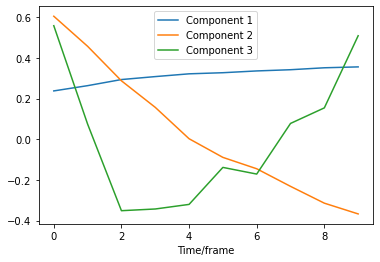

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Showing comparisons for Tensor 2!


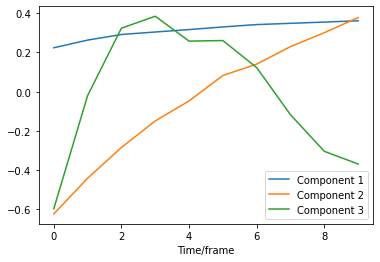

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Showing comparisons for Tensor 3!


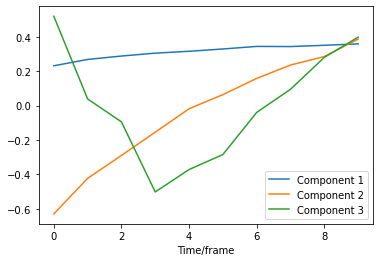

In [16]:
for ind,(ijk, tuck) in enumerate(zip([IJK1,IJK2,IJK3],[Tucker1,Tucker2,Tucker3])):
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print(f"Showing comparisons for Tensor {ind+1}!")
    tucker_plotter_timecomponent(tuck,ijk)

As the goal is to compare tensor 3 with tensors 1 and 2, unfortunately there is not much to be seen with this method! But it was worth a shot. Components 1 and 3 have opposite patterns in tensor 3 as those in tensors 1 and 2, but, component 2 for tensor 3 DOES share a similar pattern (a steady, almost linear decrease) as tensor 1. Thus, very weak reasoning to support further my growing argument that tensors 3 and 1 are from the same material. None of the components have similar patterns to tensor 2. 


-----------------------


Now, I will perform a similar analysis as done above for the CP components, in that I will take the outer product of each column of the A and B components, and plot them for tensors 1, 2, and 3, as well as calculate the distance between 1 and 3, and 2 and 3 for each resulting outer product! 

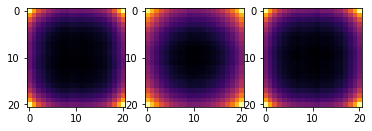

Norm of T1-T3:0.024973540173174748
Norm of T2-T3:0.12862343489012806


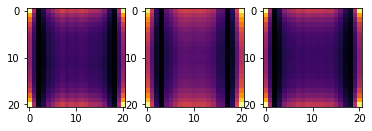

Norm of T1-T3:0.04737395707902232
Norm of T2-T3:0.165853819448213


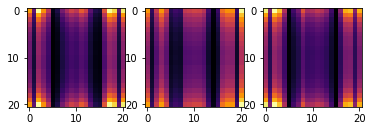

Norm of T1-T3:0.181030543066099
Norm of T2-T3:0.30965261661297555


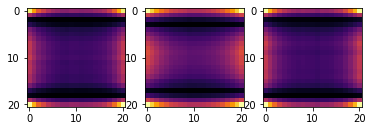

Norm of T1-T3:0.042755304155075904
Norm of T2-T3:0.18352995180811438


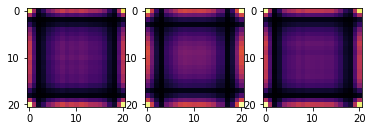

Norm of T1-T3:0.05871672628551559
Norm of T2-T3:0.2110734655203198


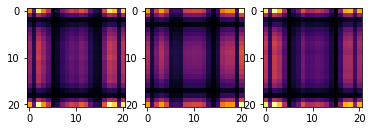

Norm of T1-T3:0.1842743363731883
Norm of T2-T3:0.3351692203152138


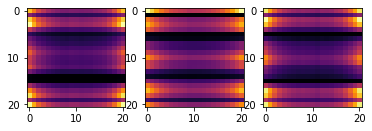

Norm of T1-T3:0.19409108008157172
Norm of T2-T3:0.31885861546174676


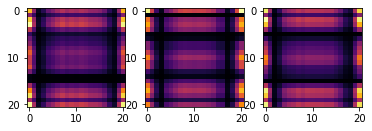

Norm of T1-T3:0.19814623921623084
Norm of T2-T3:0.3349086170130903


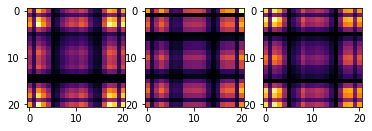

Norm of T1-T3:0.26310459924157964
Norm of T2-T3:0.4214337321126278


In [17]:
for i,j in product(range(IJK1[0]),range(IJK1[1])):
    cdists = []
    for ind,tucker in enumerate([Tucker1,Tucker2,Tucker3]):
        plt.subplot(1,3,ind+1)
        A = tucker[1][0][:,i]
        B = tucker[1][1][:,j]
        XY = np.abs(np.outer(A,B))
        plt.imshow(XY,cmap='inferno')
        cdists.append(XY)
    plt.show()
    print(f"Norm of T1-T3:{np.linalg.norm(cdists[0]-cdists[2])}")
    print(f"Norm of T2-T3:{np.linalg.norm(cdists[1]-cdists[2])}")

As can be seen, these results very consistently show that tensors 1 and 3 are the most similar, by looking at the norms. It's hard to tell just by qualitatively looking at the resulting images, but, for some of the pairs, it's easy to see the similarities between 1 and 3, such as in the first set (the corners of the resulting matrix from tensor 2 has higher-value corners than 1 and 3), #4 (the left and right edges have higher values deeper into the middle of the resulting matrix from tensor 2 than from  1 and 3), and #5 (again, notice the left and right edges). 

Finally, to wrap this up, I will re-create the tensors from their tucker decompositions, and compare the distances between recreated-tensor 1 and 3, and 2 and 3, as suggested in Piazza. 

In [18]:
recon_T1 = tl.tucker_to_tensor(tl.decomposition.tucker(T1,[3,3,3]))
recon_T2 = tl.tucker_to_tensor(tl.decomposition.tucker(T2,[3,3,3]))
recon_T3 = tl.tucker_to_tensor(tl.decomposition.tucker(T3,[3,3,3]))

print(np.linalg.norm(recon_T1-recon_T3))
print(np.linalg.norm(recon_T2-recon_T3))

1.802519843018916
9.741573182347935


Again, to no surprise, 1 and 3 are much more "close" than 2 and 3. 


THUS, **I have come to the conclusion that Tensor 3 IS from material 1! Based on a lot of supporting evidence as described above**. 

----------------------

As for comparing CP vs tucker decomposition, tucker decomposition definitely gave more consistent results when comparing the outer products of each column of components A and B, whereas CP decomposition had somewhat mixed results. Furthermore, *GIVEN THAT tensor 3 is from material 1*, I can compare the distances between the recreations of 1 and 3 from both CP and tucker, which I already did above! 

When calculating the distances between 1 and 3 using the recreated tensors from CP decomposition, I got a norm value of 3.524, whereas, when calculating the norm between the recreations of 1 and 3 from components from tucker decomposition, I got a value of 1.803, which is about HALF that of CP. Thus, it seems that tucker is much better and more able to correctly identify tensor 3 as being most similar to tensor 1, than CP. 

Thus, in summary, **I found tucker decomposition to have better results**.